## 3. Preprocessing and modeling

In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, confusion_matrix,
    classification_report, RocCurveDisplay, PrecisionRecallDisplay)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

### Load data

In [6]:
df = pd.read_csv("user_features.csv") 
df.shape, df.head()

((10000, 33),
       user_id                      email first_name last_name   age  gender  \
 0  user_00001   figueroajohn@example.org      Erica     Garza  43.0    Male   
 1  user_00002      blakeerik@example.com     Joshua   Bernard  38.0    Male   
 2  user_00003        smiller@example.net    Barbara  Williams  32.0  Female   
 3  user_00004  mitchellclark@example.com    Chelsea  Ferguson  11.0    Male   
 4  user_00005      richard13@example.net      Jason    Foster  21.0  Female   
 
   country state_province                city subscription_plan  ...  \
 0     USA  Massachusetts  North Jefferyhaven             Basic  ...   
 1     USA          Texas      North Noahstad          Premium+  ...   
 2     USA       Michigan          Traciebury          Standard  ...   
 3     USA           Ohio          South Noah          Standard  ...   
 4     USA        Arizona         West Donald          Standard  ...   
 
   search_count  avg_results_returned  click_rate avg_search_duration 

### Target and features

We start by defining the target and dropping fields that could give the model an unfair advantage (such as status flags, raw timestamps or unique identifiers) so that our baselines reflect true predictive power.

In [8]:
target = "churn"  
y = df[target].astype(int)
X = df.drop(columns=[target])

# Drop identifiers if present
id_like = [c for c in X.columns if "id" in c.lower() or "email" in c.lower()]
X = X.drop(columns=id_like)

num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

num_cols, cat_cols

(['age',
  'is_active',
  'monthly_spend',
  'household_size',
  'tenure_days',
  'total_watch_time',
  'avg_watch_time',
  'completion_rate',
  'num_sessions',
  'rated_movies',
  'search_count',
  'avg_results_returned',
  'click_rate',
  'avg_search_duration',
  'avg_rating',
  'review_count',
  'avg_sentiment',
  'rec_count',
  'rec_clicks',
  'rec_ctr'],
 ['first_name',
  'last_name',
  'gender',
  'country',
  'state_province',
  'city',
  'subscription_plan',
  'subscription_start_date',
  'primary_device',
  'created_at'])

In [10]:
# Remove leakage and uninformative fields
drop_cols = [
    "is_active", "first_name", "last_name", 
    "subscription_start_date", "created_at",
    "city", "state_province"   # drop high-cardinality location fields
]

X = X.drop(columns=drop_cols, errors="ignore")

# Rebuild lists
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

num_cols, cat_cols

(['age',
  'monthly_spend',
  'household_size',
  'tenure_days',
  'total_watch_time',
  'avg_watch_time',
  'completion_rate',
  'num_sessions',
  'rated_movies',
  'search_count',
  'avg_results_returned',
  'click_rate',
  'avg_search_duration',
  'avg_rating',
  'review_count',
  'avg_sentiment',
  'rec_count',
  'rec_clicks',
  'rec_ctr'],
 ['gender', 'country', 'subscription_plan', 'primary_device'])

We transform categorical features using one-hot encoding, while numeric features are median-imputed and standardized. This ensures that all baselines are trained on a consistent and comparable feature set.

### Pipeline setup

In [12]:
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preproc = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

### Train/test split

We then split the dataset into an 80-20 train/test split. 
- Train set : 8000 users (85% active, 15% churned)  
- Test set : 2000 users (85% active, 15% churned)  

This ensures both sets preserve the original churn imbalance (about 15%).  

The training set will be used for fitting and tuning models, while the test set serves as an unbiased evaluation of baseline performance.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% test set
    stratify=y,           # preserve churn ratio
    random_state=42       # reproducibility
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Churn ratio in train:", y_train.mean().round(3))
print("Churn ratio in test :", y_test.mean().round(3))

Train size: (8000, 23) Test size: (2000, 23)
Churn ratio in train: 0.148
Churn ratio in test : 0.148


### Evaluation

We define a helper function "eval_model()" to standardize how each model is evaluated and make it easier to compare each model side by side. 

The function:
- Trains the model on the training data and makes predictions on the test set.
- Calculates a set of metrics designed for imbalanced classification problems:
    - ROC AUC: to measure overall discrimination.
    - PR AUC(Precision–Recall Area): more informative than ROC when churn is rare.
    - F1, Recall and Precision to capture the trade-off between identifying churners and avoiding false alarms.
- Produces a confusion matrix and a classification report.
- Plots both the ROC and Precision Recall curves to visualize model performance.

In [16]:
def eval_model(pipe, X_train, y_train, X_test, y_test, name="Model"):
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None
    pred  = pipe.predict(X_test)

    out = {}
    if proba is not None:
        out["ROC AUC"] = roc_auc_score(y_test, proba)
        out["PR AUC"]  = average_precision_score(y_test, proba)
    out["F1"]        = f1_score(y_test, pred)
    out["Recall"]    = recall_score(y_test, pred)
    out["Precision"] = precision_score(y_test, pred, zero_division=0)

    print(f"\n=== {name} ===")
    print(pd.Series(out).round(4))
    print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))
    print("\nClassification report:\n",
          classification_report(y_test, pred, digits=3, zero_division=0))

    if proba is not None:
        fig, ax = plt.subplots(1, 2, figsize=(10,4))
        RocCurveDisplay.from_predictions(y_test, proba, ax=ax[0]); ax[0].set_title(f"ROC — {name}")
        PrecisionRecallDisplay.from_predictions(y_test, proba, ax=ax[1]); ax[1].set_title(f"PR — {name}")
        plt.tight_layout(); plt.show()

    return pd.Series(out, name=name)

### Baseline models

We now evaluate three simple baselines: 
- Dummy classifier(majority class): the model always predicts the most common outcome (active). 
- Logistic Regression (balanced)
- Random Forest (balanced): the algorithm adjusts class weights so churners and non-churners contribute equally to training.

In [18]:
# Dummy classifier 
dummy_pipe = Pipeline([
    ("prep", preproc),
    ("clf", DummyClassifier(strategy="most_frequent"))
])

In [20]:
# Logistic Regression 
logreg_pipe = Pipeline([
    ("prep", preproc),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced", random_state=RANDOM_STATE))
])

In [22]:
# Random Forest 
rf_pipe = Pipeline([
    ("prep", preproc),
    ("clf", RandomForestClassifier(
        n_estimators=300, min_samples_leaf=2, class_weight="balanced",
        n_jobs=-1, random_state=RANDOM_STATE
    ))
])

In [48]:
# XGBoost
!pip install xgboost

from xgboost import XGBClassifier

xgb_pipe = Pipeline([
    ("prep", preproc),
    ("clf", XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1]), # handle imbalance
        random_state=42,
        eval_metric="logloss"
    ))
])

### Comparing baseline models 


=== Dummy (majority) ===
ROC AUC      0.500
PR AUC       0.148
F1           0.000
Recall       0.000
Precision    0.000
dtype: float64

Confusion matrix:
 [[1704    0]
 [ 296    0]]

Classification report:
               precision    recall  f1-score   support

           0      0.852     1.000     0.920      1704
           1      0.000     0.000     0.000       296

    accuracy                          0.852      2000
   macro avg      0.426     0.500     0.460      2000
weighted avg      0.726     0.852     0.784      2000



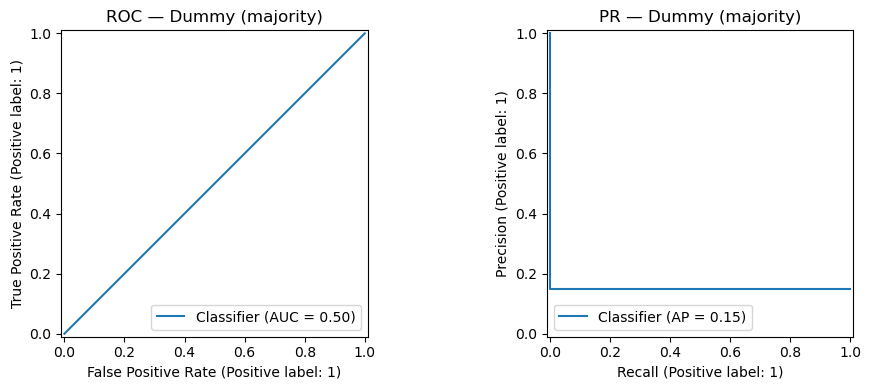


=== Logistic Regression (balanced) ===
ROC AUC      0.4398
PR AUC       0.1335
F1           0.1903
Recall       0.4054
Precision    0.1244
dtype: float64

Confusion matrix:
 [[859 845]
 [176 120]]

Classification report:
               precision    recall  f1-score   support

           0      0.830     0.504     0.627      1704
           1      0.124     0.405     0.190       296

    accuracy                          0.489      2000
   macro avg      0.477     0.455     0.409      2000
weighted avg      0.726     0.489     0.563      2000



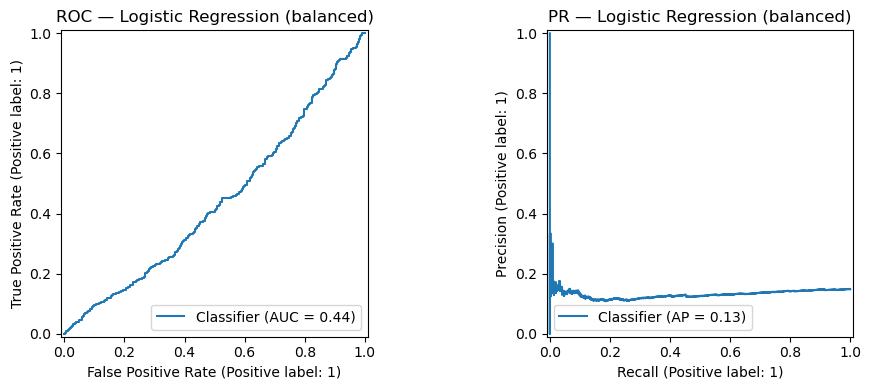


=== Random Forest (balanced) ===
ROC AUC      0.4917
PR AUC       0.1398
F1           0.0000
Recall       0.0000
Precision    0.0000
dtype: float64

Confusion matrix:
 [[1704    0]
 [ 296    0]]

Classification report:
               precision    recall  f1-score   support

           0      0.852     1.000     0.920      1704
           1      0.000     0.000     0.000       296

    accuracy                          0.852      2000
   macro avg      0.426     0.500     0.460      2000
weighted avg      0.726     0.852     0.784      2000



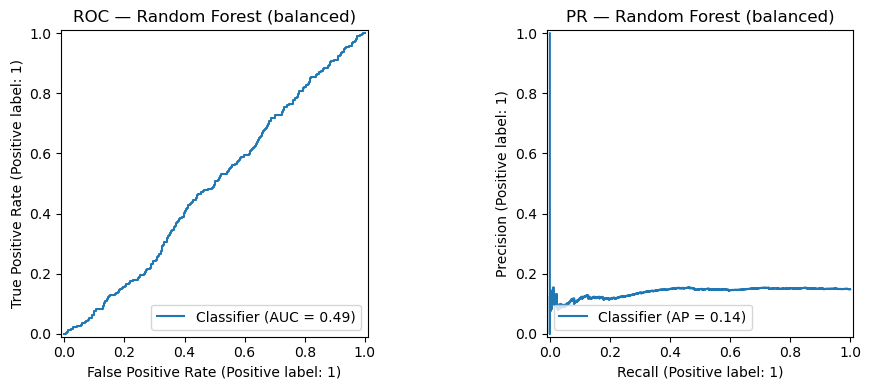


=== XGBoost (baseline) ===
ROC AUC      0.5104
PR AUC       0.1526
F1           0.1355
Recall       0.1250
Precision    0.1480
dtype: float64

Confusion matrix:
 [[1491  213]
 [ 259   37]]

Classification report:
               precision    recall  f1-score   support

           0      0.852     0.875     0.863      1704
           1      0.148     0.125     0.136       296

    accuracy                          0.764      2000
   macro avg      0.500     0.500     0.499      2000
weighted avg      0.748     0.764     0.756      2000



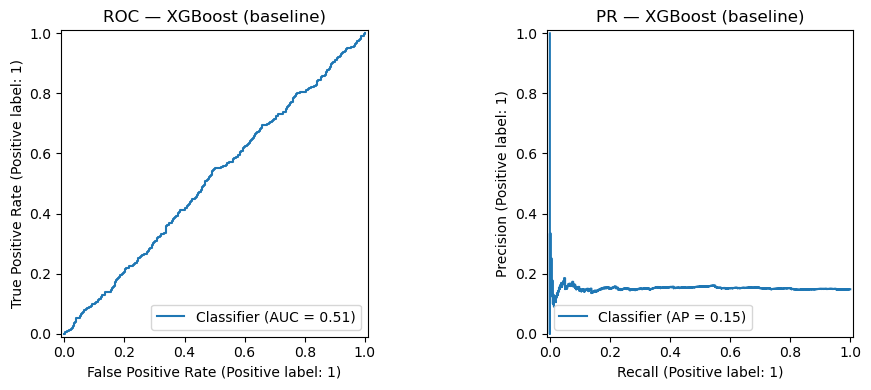

In [50]:
# Evaluate baselines
m_dummy = eval_model(dummy_pipe, X_train, y_train, X_test, y_test, "Dummy (majority)")
m_log = eval_model(logreg_pipe, X_train, y_train, X_test, y_test, "Logistic Regression (balanced)")
m_rf = eval_model(rf_pipe,    X_train, y_train, X_test, y_test, "Random Forest (balanced)")
m_xgb = eval_model(xgb_pipe, X_train, y_train, X_test, y_test, "XGBoost (baseline)")

### Metric table

In [43]:
metrics_tbl = pd.concat([m_dummy, m_log, m_rf, m_xgb], axis=1).T
metrics_tbl.sort_values("PR AUC", ascending=False, inplace=True)
metrics_tbl

,ROC AUC,PR AUC,F1,Recall,Precision
XGBoost (baseline),0.510436,0.152613,0.135531,0.125000,0.148000
Dummy (majority),0.500000,0.148000,0.000000,0.000000,0.000000
Random Forest (balanced),0.491695,0.139825,0.000000,0.000000,0.000000
Logistic Regression (balanced),0.439774,0.133487,0.190325,0.405405,0.124352


### Baseline results and selection

The baseline comparisons show clear differences in performance across models:

- **Logistic Regression (balanced)** achieved PR AUC = 0.133, which is below the Dummy baseline of 0.148. Despite 41% recall, precision was only 0.12, creating too many false positives. 
- **Random Forest (balanced)** collapsed entirely, predicting only the majority class with 0 recall.
- **The Dummy Classifier** remains our benchmark to beat, as neither Logistic Regression nor Random Forest surpassed it on PR AUC.
- **XGBoost** slightly outperformed the Dummy baseline (PR AUC = 0.153), while also recovering a small part of churners (Recall = 0.125). Even though the improvement is small, it shows that boosting methods can already detect weak signals and are likely to improve with stronger features.

This outcome highlights the difficulty of churn prediction after removing leakage and high-cardinality features. Simple models struggle to find signal, but XGBoost demonstrates that more advanced methods can begin to capture subtle patterns. The next phase will focus on feature engineering and tuning to strengthen these signals and build models that deliver actionable recall and precision.

### Next Steps: Feature engineering and boosting 

The initial goal of this project is **Netflix customer churn: identifying the behavioral drivers of user retention and departure**.  
The baseline comparison confirms that churn prediction is a challenging task: simple linear and default tree models cannot extract meaningful separation between churners and active users. However, XGBoost showed the first signs of improvement, slightly surpassing the Dummy baseline (PR AUC = 0.153 vs. 0.148) and recovering a small share of churners. 

This shows that boosting methods can detect weak signals in the data and will likely perform better with stronger features. 

The next phase will focus on:

- **Feature engineering**: ratios, recency measures and interactions.  
- **Imbalance handling**: class weights, resampling and threshold tuning.  
- **Advanced models**: gradient boosting (XGBoost with tuning and feature enrichment).
- **Evaluation**: PR AUC as the primary metric (with recall at precision thresholds for business focus).


**Final goal:** Use XGBoost's progress to build models that beat the Dummy baseline, balance recall and precision and reveal the behaviors that drive churn and retention.